In [1]:
from IPython.display import display
from ipywidgets import ToggleButton

COLAB = False

tb = ToggleButton(
    value=False,
    description='Google Collab',
    disabled=False,
    button_style='success',
    icon='google'
)

def set_variable(change):
    global COLAB
    COLAB = change.new
    print('\r', "Google Colab:", COLAB, end=' ')

tb.observe(set_variable, names='value')

display(tb)

ToggleButton(value=False, button_style='success', description='Google Collab', icon='google')

In [2]:
import os

if COLAB:
    %pip install monai
    %pip install wfdb

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

PATH = os.getcwd() if not COLAB else "/content/drive/MyDrive/ECG"

In [3]:
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import numpy as np
import random
import wfdb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import interpolate
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from monai.losses import DiceCELoss

## Models

#### U-Net 1D

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, inp, out):
        super(ConvBlock, self).__init__()

        self.dounle_conv = nn.Sequential(
            nn.Conv1d(inp, out, kernel_size=9, stride=1, padding=8, dilation=2),
            nn.BatchNorm1d(out),
            nn.ReLU(),
            nn.Conv1d(out, out, kernel_size=9, stride=1, padding=8, dilation=2),
            nn.BatchNorm1d(out),
            nn.ReLU(),
        )

    def forward(self, inputs):
        return self.dounle_conv(inputs)


class Encoder(nn.Module):
    def __init__(self, dims):
        super(Encoder, self).__init__()

        self.encoder_blocks = nn.ModuleList([ConvBlock(dims[i], dims[i+1]) for i in range(len(dims)-2)])
        self.compressions = nn.ModuleList([nn.Conv1d(dims[i+1], dims[i+1], kernel_size=3, stride=2, padding=1, dilation=1) for i in range(len(dims)-2)])
        self.drop = nn.Dropout(0.05)

    def forward(self, x):
        features = []
        for i, block in enumerate(self.encoder_blocks):
            x = block(x)
            features.append(x)
            x = self.compressions[i](x)

        return x, features


class Decoder(nn.Module):
    def __init__(self, dims):
        super(Decoder, self).__init__()
        
        self.expansions = nn.ModuleList([nn.ConvTranspose1d(dims[i], dims[i+1], kernel_size=2, stride=2) for i in range(len(dims)-2)])
        self.decoder_blocks = nn.ModuleList([ConvBlock(dims[i], dims[i+1]) for i in range(len(dims)-2)])

    def forward(self, x, skip):
        for i, block in enumerate(self.decoder_blocks):
            x = self.expansions[i](x)
            x = torch.cat([skip[i], x], dim=1)
            x = block(x)

        return x


class UNet_1d(nn.Module):
    def __init__(self, enc_dims=(1, 64, 128, 256, 512, 1024, 2048), dec_dims=(2048, 1024, 512, 256, 128, 64, 4)):
        super(UNet_1d, self).__init__()

        self.encoder = Encoder(enc_dims)
        self.decoder = Decoder(dec_dims)

        self.bottleneck = nn.Sequential(nn.Conv1d(enc_dims[-2], enc_dims[-2], kernel_size=3, stride=1, padding=3, dilation=3),
                                        nn.Conv1d(enc_dims[-2], dec_dims[0], kernel_size=3, stride=1, padding=3, dilation=3))

        self.last_conv = nn.Conv1d(dec_dims[-2], dec_dims[-1], kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, skip = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x, skip[::-1])
        x = self.last_conv(x)
        x = self.sigmoid(x)

        return x

#### U-Net 2D

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, inp, out):
        super(ConvBlock, self).__init__()

        self.dounle_conv = nn.Sequential(
            nn.Conv2d(inp, out, kernel_size=9, stride=1, padding=8, dilation=2),
            nn.BatchNorm2d(out),
            nn.ReLU(),
            nn.Conv2d(out, out, kernel_size=9, stride=1, padding=8, dilation=2),
            nn.BatchNorm2d(out),
            nn.ReLU(),
        )

    def forward(self, inputs):
        return self.dounle_conv(inputs)


class Encoder(nn.Module):
    def __init__(self, dims):
        super(Encoder, self).__init__()

        self.encoder_blocks = nn.ModuleList([ConvBlock(dims[i], dims[i+1]) for i in range(len(dims)-2)])
        self.compressions = nn.ModuleList([nn.Conv2d(dims[i+1], dims[i+1], kernel_size=3, stride=(1,2), padding=1, dilation=1) for i in range(len(dims)-2)])
        self.drop = nn.Dropout(0.05)

    def forward(self, x):
        features = []
        for i, block in enumerate(self.encoder_blocks):
            x = block(x)
            features.append(x)
            x = self.compressions[i](x)

        return x, features


class Decoder(nn.Module):
    def __init__(self, dims):
        super(Decoder, self).__init__()
        
        self.expansions = nn.ModuleList([nn.ConvTranspose2d(dims[i], dims[i+1], kernel_size=(1,2), stride=(1,2)) for i in range(len(dims)-2)])
        self.decoder_blocks = nn.ModuleList([ConvBlock(dims[i], dims[i+1]) for i in range(len(dims)-2)])
        
    def forward(self, x, skip):
        for i, block in enumerate(self.decoder_blocks):
            x = self.expansions[i](x)
            x = torch.cat([skip[i], x], dim=1)
            x = block(x)

        return x


class UNet_2d(nn.Module):
    def __init__(self, enc_dims=(1, 64, 128, 256, 512), dec_dims=(512, 256, 128, 64, 4)):
        super(UNet_2d, self).__init__()

        self.encoder = Encoder(enc_dims)
        self.decoder = Decoder(dec_dims)

        self.bottleneck = nn.Sequential(nn.Conv2d(enc_dims[-2], enc_dims[-2], kernel_size=3, stride=1, padding=3, dilation=3),
                                        nn.Conv2d(enc_dims[-2], dec_dims[0], kernel_size=3, stride=1, padding=3, dilation=3))

        self.last_conv = nn.Conv2d(dec_dims[-2], dec_dims[-1], kernel_size=(1,1), stride=1, padding=0)
        self.pool = nn.AvgPool2d(kernel_size=(100,1), stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, skip = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x, skip[::-1])
        x = self.last_conv(x)
        x = self.pool(x)
        x = self.sigmoid(x)

        return x

## Data

In [6]:
DATA_PATH = R".\lobachevsky-university-electrocardiography-database-1.0.1\data" if not COLAB \
  else R"/content/drive/MyDrive/ECG/lobachevsky-university-electrocardiography-database-1.0.1/data"

LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
SEGMENTS_COLORS = {
    'p': 'red',
    'N': 'blue',
    't': 'green',
}
CATEGORIES = {
    'p': 0,
    'N': 1,
    't': 2
}

# all functions are based on WFDB format

In [7]:
def check_group(func):
    def wrapper(itr, n=3):
        if not isinstance(itr, (list, np.ndarray)):
            raise ValueError(f"Error in {func.__name__}() function: Input 'itr' must be a list or np.ndarray")
        if not isinstance(n, int) or n <= 0:
            raise ValueError("Input 'n' must be a positive integer")

        return func(itr, n)
    return wrapper


@check_group
def group(itr, n=3):
    itr = iter(itr)
    end = object()
    while True:
        vals = tuple(next(itr, end) for _ in range(n))
        if vals[-1] is end:
            return
        yield vals


def correct(points, symbols, left=0, right=5000):
    points_ = []
    symbols_ = []
    for i in range(2, len(points)):
        if points[i] >= left and points[i] < right:
            if i == 2 and symbols[i-2] in ['p', 'N', 't'] and symbols[i-1] == ')' and symbols[i] == '(':   # | s ) (
                symbols_.append('(')
                symbols_.append(symbols[i-2])
                symbols_.append(')')
                points_.append(points[i-2])
                points_.append(points[i-2] + 1)
                points_.append(points[i-1])

            elif symbols[i-2] == '(' and symbols[i-1] in ['p', 'N', 't'] and symbols[i] == ')':   # ( s )
                symbols_.append('(')
                symbols_.append(symbols[i-1])
                symbols_.append(')')
                points_.append(points[i-2])
                points_.append(points[i-1])
                points_.append(points[i])

            elif symbols[i-2] in ['p', 'N', 't'] and symbols[i-1] == '(' and symbols[i] == ')':   # s ( )
                symbols_.append('(')
                symbols_.append(symbols[i-2])
                symbols_.append(')')
                points_.append(points[i-2])
                points_.append(points[i-1])
                points_.append(points[i])

            elif symbols[i-2] == ')' and symbols[i-1] in ['p', 'N', 't'] and symbols[i] == ')':   # ) s )
                symbols_.append('(')
                symbols_.append(symbols[i-1])
                symbols_.append(')')
                points_.append(points[i-1])
                points_.append(points[i-1] + 1)
                points_.append(points[i])

    return np.array(points_)-left, np.array(symbols_)

In [8]:
class EcgDataset(Dataset):

    def __init__(self, dir, duration, X, Y, random_shift=False, spectrogram=None):
        self.dir = dir
        self.duration = duration
        shifts = [random.randint(200, (5000 - self.duration)//2) for i in range(len(X))]
        self.left = [(5000 - self.duration)//2 for i in range(len(X))] if not random_shift else shifts
        self.right = [(5000 + self.duration)//2 for i in range(len(X))] if not random_shift else [sh + self.duration for sh in shifts]
        self.X = X
        self.Y = Y
        self.spec = spectrogram


    def __len__(self):
        return len(self.X)
    

    def get_signal(self, index):
        return wfdb.rdrecord(self.dir+f"/{self.X[index] + 1}").p_signal.T[self.Y[index]][self.left[index] : self.right[index]]
    

    def get_segmentation(self, index):
        annotation = wfdb.rdann(self.dir+f"/{self.X[index] + 1}", extension=LEADS[self.Y[index]])
        category = np.full(self.duration, -1)

        points, symbols = correct(annotation.sample, annotation.symbol, self.left[index], self.right[index])

        for start, peak, stop in group(points):
            k = np.nonzero(points == peak)[0][0]
            category[start:stop] = CATEGORIES[symbols[k]]
        return np.eye(4, dtype='uint8')[category + 1].T
    

    def ecg_seg_plot(self, index, seg=None, spec=False):
        plt.figure(figsize=(20, 2))
        plt.style.use('default')
        plt.gca().set_facecolor('#ffd5ce')
        plt.gca().spines[:].set_color('salmon')
        plt.gca().spines[:].set_linewidth(2)
        plt.gcf().set_facecolor('linen')
        plt.gca().tick_params(color='salmon', width=2)
        plt.grid(color='salmon', linestyle='-', linewidth=2, zorder=1)

        ECG = self.get_signal(index)
        TIME = np.arange(0, ECG.shape[0], 1)
        plt.plot(TIME, ECG, color='black', zorder=3)

        seg = self.get_segmentation(index) if seg is None else seg
        for ch in range(1, 4):
            start, end = 10000, 0
            for i, num in enumerate(seg[ch]):
                if num == 1 and i < start:
                    start = i
                if num == 1 and i > end:
                    end = i
                if num == 0 and end > start:
                    plt.axvspan(start, end, color=list(SEGMENTS_COLORS.values())[ch-1], alpha=0.3, zorder=2)
                    start, end = 10000, 0


    def __getitem__(self, index):
        if self.spec != None:
            s = torch.tensor(signal.spectrogram(self.get_signal(index), **self.spec)[2], dtype=torch.float32).unsqueeze(0)
            m = interpolate(torch.tensor(self.get_segmentation(index), dtype=torch.float32).unsqueeze(1), size=s.shape[2])
            return s, m
        
        return torch.tensor(self.get_signal(index), dtype=torch.float32).unsqueeze(0),\
               torch.tensor(self.get_segmentation(index), dtype=torch.float32)

$X = [\underbrace{0, \dots, 0}_{12},\ \underbrace{1, \dots, 1}_{12},\ \underbrace{2, \dots, 2}_{12}, \dots]$

$Y = [\underbrace{0, \dots, 11}_{12},\ \underbrace{0, \dots, 11}_{12},\ \underbrace{0, \dots, 11}_{12}, \dots]$

In [9]:
def get_loaders(
    dir,
    duration,
    random_shift,
    spectrogram,
    number_of_patients,
    val_size,
    test_size,
    shuffle,
    batch_size,
    num_workers=0,
    pin_memory=True,
):
    X = [i//12 for i in range(0, number_of_patients*12)]
    Y = [i%12 for i in range(0, number_of_patients*12)]
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=val_size+test_size, shuffle=shuffle)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=test_size/(test_size+val_size), shuffle=shuffle)

    train_ds = EcgDataset(
        dir=dir,
        duration=duration,
        X=X_train,
        Y=Y_train,
        random_shift=random_shift,
        spectrogram=spectrogram
    )

    train_loader = DataLoader(
        dataset=train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    val_ds = EcgDataset(
        dir=dir,
        duration=duration,
        X=X_val,
        Y=Y_val,
        random_shift=random_shift,
        spectrogram=spectrogram
    )

    val_loader = DataLoader(
        dataset=val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    test_ds = EcgDataset(
        dir=dir,
        duration=duration,
        X=X_test,
        Y=Y_test,
        random_shift=random_shift,
        spectrogram=spectrogram
    )

    test_loader = DataLoader(
        dataset=test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 0.0001
BATCH_SIZE    = 1
EPOCHS        = 3
NUM_WORKERS   = 0
PIN_MEMORY    = False
LOAD_MODEL    = False

NUMBER_OF_PATIENTS = int(len(os.listdir(DATA_PATH))/14)
NUMBER_OF_PATIENTS = 2
VAL_SIZE = 0.2
TEST_SIZE = 0.1

SIGNAL_DURATION = 4000
FREQUENCY       = 500
RANDOM_SHIFT    = True
SHUFFLE         = True
SPECTROGRAM     = {'fs': FREQUENCY,
              'nperseg': 33,
             'noverlap': 29,
                 'nfft': 198}
# SPECTROGRAM     = None

ENC_DIMS = (1, 64, 128, 256, 512, 1024, 2048) if SPECTROGRAM is None else (1, 64, 128, 256, 512)
DEC_DIMS = (2048, 1024, 512, 256, 128, 64, 4) if SPECTROGRAM is None else (512, 256, 128, 64, 4)

In [11]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)


train_loader, val_loader, test_loader = get_loaders(
    DATA_PATH,
    SIGNAL_DURATION,
    RANDOM_SHIFT,
    SPECTROGRAM,
    NUMBER_OF_PATIENTS,
    VAL_SIZE,
    TEST_SIZE,
    SHUFFLE,
    BATCH_SIZE,
    NUM_WORKERS,
    PIN_MEMORY,
)

In [12]:
m = UNet_2d()

In [13]:
d = train_loader.dataset

d[0][0].shape, d[0][1].shape

m(d[0][0].unsqueeze(0)).shape

torch.Size([1, 4, 1, 992])

## Train

In [14]:
def print_dict(name: str, d: dict):
    l = len(max(d.keys(), key=len))
    print(f"{name}:")
    for key in d.keys():
        print(f"    {' ' * (l - len(key))}{key}: {d[key]}")


def save(epoch, model, optimizer, loss, HISTORY, path):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        'loss': loss,
        'history': HISTORY
    }, PATH + path)

In [15]:
def fit_epoch(model, loader, loss_fn, optimizer, scaler):
    model.train()
    loop = tqdm(loader)

    running_loss = 0.0
    running_corrects = 0
    num_pixels = 0
    processed_size = 0
    dice_score = {"no seg": 0,
                  "P": 0,
                  "R": 0,
                  "T": 0}

    for idx, (x, y) in enumerate(loop):
        x = x.to(device=DEVICE)
        y = y.to(device=DEVICE)

        optimizer.zero_grad()
        predictions = model(x)
        loss = loss_fn(predictions, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

        running_loss += loss.item() * x.size(0)
        running_corrects += torch.sum((predictions > 0.8) == y)
        num_pixels += torch.numel(x)
        processed_size += x.size(0)

        for i, key in enumerate(dice_score.keys()):
                dice_score[key] += (2 * (predictions[:, i] * y[:, i]).sum()) / ((predictions[:, i] + y[:, i]).sum() + 1e-8)
    
    train_loss = running_loss / processed_size
    train_acc = running_corrects.cpu().numpy() / num_pixels
    for i, key in enumerate(dice_score.keys()):
        dice_score[key] = dice_score[key].cpu().detach().numpy() / len(loader)

    return train_loss, train_acc, dice_score


def eval_epoch(model, loader, loss_fn):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    num_pixels = 0
    processed_size = 0
    dice_score = {"no seg": 0,
                  "P": 0,
                  "R": 0,
                  "T": 0}

    for idx, (x, y) in enumerate(loader):
        x = x.to(device=DEVICE)
        y = y.to(device=DEVICE)

        with torch.no_grad():
            predictions = model(x)
            loss = loss_fn(predictions, y)

            running_loss += loss.item() * x.size(0)
            running_corrects += torch.sum((predictions > 0.8) == y)
            num_pixels += torch.numel(x)
            processed_size += x.size(0)

            for i, key in enumerate(dice_score.keys()):
                dice_score[key] += (2 * (predictions[:, i] * y[:, i]).sum()) / ((predictions[:, i] + y[:, i]).sum() + 1e-8)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / num_pixels
    for i, key in enumerate(dice_score.keys()):
        dice_score[key] = dice_score[key].cpu().detach().numpy() / len(loader)

    print(f"Got {running_corrects}/{num_pixels} with acc {running_corrects/num_pixels*100:.2f}")
    print_dict("Dice Score", dice_score)

    return val_loss, val_acc, dice_score

In [16]:
def train(model, scaler, start=0, checkpoint=None, prev_best_val_loss=None):

    if checkpoint is not None:  
        checkpoint = torch.load(checkpoint)
        HISTORY = checkpoint["history"]
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer_d = checkpoint["optimizer_state_dict"]
        prev_best_val_loss = checkpoint["loss"]
    else:
        HISTORY = []

    if prev_best_val_loss is None:
        best_val_loss = torch.inf
    else:
        best_val_loss = prev_best_val_loss

    log_template = "Epoch {ep} || train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}\n"
    

    with tqdm(desc="TOTAL", total=EPOCHS-start) as pbar_outer:
        optimizer = torch.optim.AdamW([dict(params=model.parameters(), lr=LEARNING_RATE)])
        if checkpoint is not None:
            optimizer.load_state_dict(optimizer_d)
        loss_fn = DiceCELoss()

        for epoch in range(start, EPOCHS):
            train_loss, train_acc, train_dice = fit_epoch(model, train_loader, loss_fn, optimizer, scaler)
            print("loss:", train_loss)
            val_loss, val_acc, val_dice = eval_epoch(model, val_loader, loss_fn)

            HISTORY.append((train_loss, train_acc, train_dice, val_loss, val_acc, val_dice))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save(epoch, model, optimizer, val_loss, HISTORY, path="/checkpoints/best_checkpoint.pth")

            save(epoch, model, optimizer, val_loss, HISTORY, path=f"/checkpoints/checkpoint_{epoch}.pth")
            
            pbar_outer.update()
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    save(epoch, model, optimizer, val_loss, HISTORY, path="/checkpoints/last_checkpoint.pth")
    

In [17]:
model = UNet_1d(ENC_DIMS, DEC_DIMS).to(DEVICE) if SPECTROGRAM is None else UNet_2d(ENC_DIMS, DEC_DIMS).to(DEVICE)
scaler = torch.cuda.amp.GradScaler()

params = list(model.parameters())
print(sum(p.numel() for p in params))

34087108


c:\Users\George.LAPTOP-TLP259VH\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [18]:
train(model, scaler)

torch.Size([1, 1, 100, 992]) torch.Size([1, 4, 1, 992])




KeyboardInterrupt: 

In [ ]:
raise ValueError

ValueError: 

In [ ]:
m = model

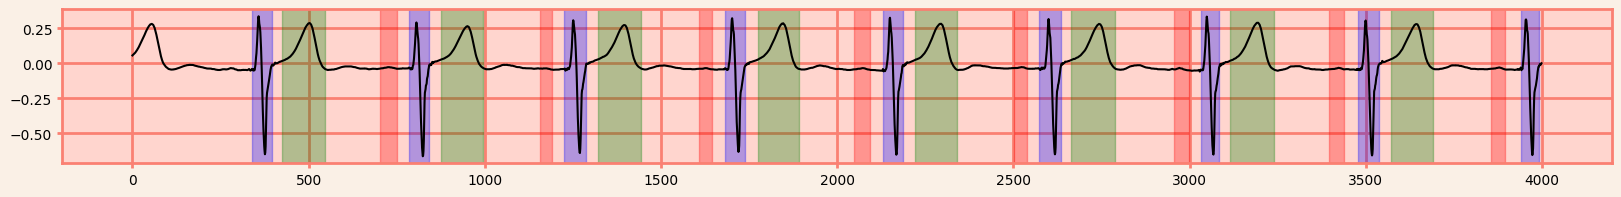

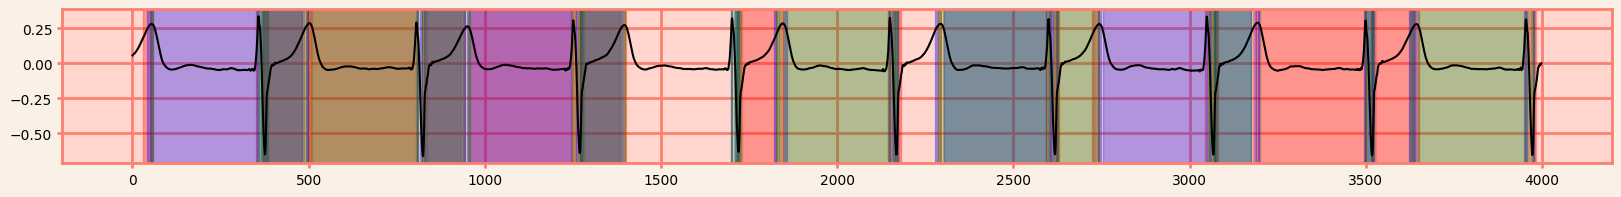

In [ ]:
x = test_loader.dataset[0][0].unsqueeze(0)
s = test_loader.dataset[0][1]

with torch.no_grad():
    p = m(x)

p[p >= 0.7] = 1
p[p < 0.7] = 0
test_loader.dataset.ecg_seg_plot(0, s)
test_loader.dataset.ecg_seg_plot(0, p[0])

0.8847609020414806

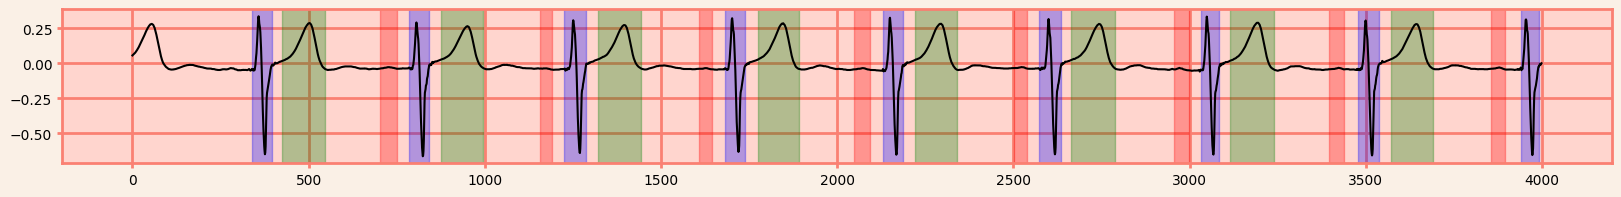

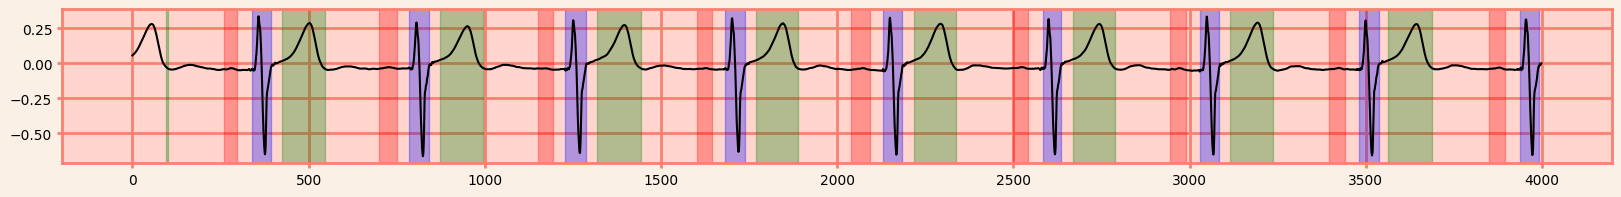

In [ ]:
ch =  torch.load(R"G:\Мой диск\ECG\checkpoints\last_checkpoint.pth", map_location=torch.device('cpu'))
H = ch['history']
m = UNet()
m.load_state_dict(ch["model_state_dict"])
m.eval()


x = test_loader.dataset[0][0].unsqueeze(0)
s = test_loader.dataset[0][1]

with torch.no_grad():
    p = m(x)

p[p >= 0.7] = 1
p[p < 0.7] = 0
test_loader.dataset.ecg_seg_plot(0, s)
test_loader.dataset.ecg_seg_plot(0, p[0])

In [ ]:
ch =  torch.load(fR"G:\Мой диск\ECG\checkpoints\checkpoint_29.pth", map_location=torch.device('cpu'))

In [ ]:
plt.figure(figsize=(10, 5))

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][2]['P'])
plt.plot(X, Y, color='red', linestyle='--', label='P')

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][5]['P'])
plt.plot(X, Y, color='red', linestyle='-', label='P_val')

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][2]['R'])
plt.plot(X, Y, color='blue', linestyle='--', label='R')

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][5]['R'])
plt.plot(X, Y, color='blue', linestyle='-', label='R_val')

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][2]['T'])
plt.plot(X, Y, color='green', linestyle='--', label='T')

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][5]['T'])
plt.plot(X, Y, color='green', linestyle='-', label='T_val')

plt.grid()
plt.legend()

NameError: name 'plt' is not defined

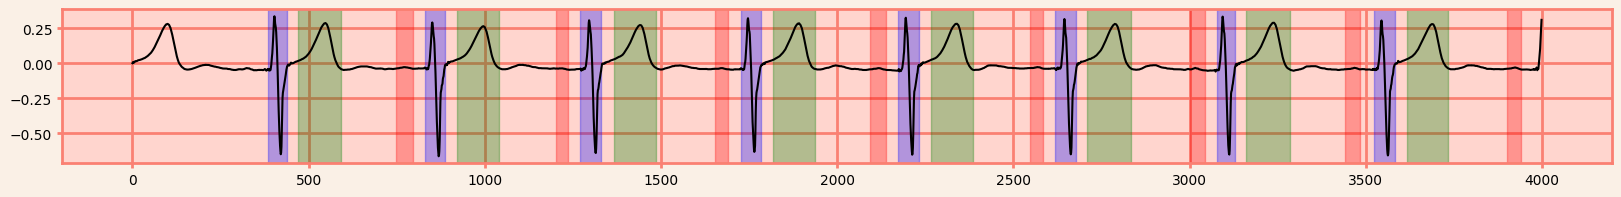

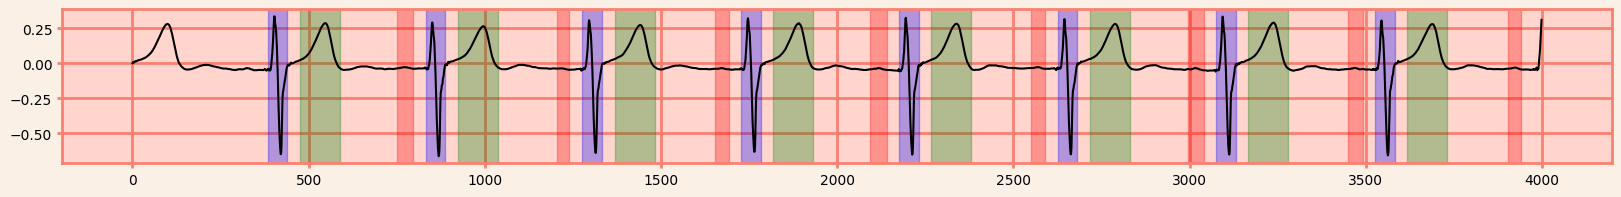

In [ ]:
m = UNet()
m.load_state_dict(ch["model_state_dict"])
m.eval()


x = test_loader.dataset[0][0].unsqueeze(0)
s = test_loader.dataset[0][1]

with torch.no_grad():
    p = m(x)

p[p >= 0.7] = 1
p[p < 0.7] = 0
test_loader.dataset.ecg_seg_plot(0, s)
test_loader.dataset.ecg_seg_plot(0, p[0])

(5000,)


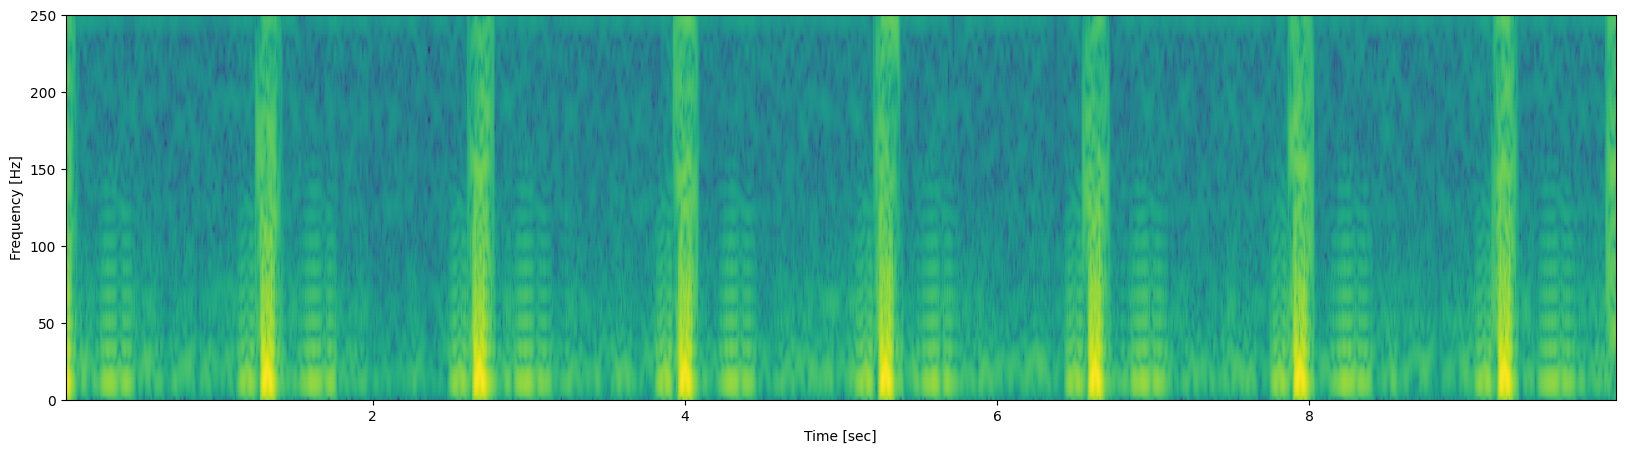

(100, 1242)

In [ ]:
# s = test_loader.dataset[0][0]

# plt.figure(figsize=(20, 5))
# a = plt.specgram(s[0], Fs=FREQUENCY, scale='dB')[0]

# test_loader.dataset.ecg_seg_plot(0)
# plt.xlim(0, 4000)

SPECTROGRAM     = {'fs': FREQUENCY,
              'nperseg': 33,
             'noverlap': 29,
                 'nfft': 198}
plt.figure(figsize=(20, 5))
s = wfdb.rdrecord(DATA_PATH+R"\1").p_signal.T[1]
print(s.shape)
f, t, Sxx = signal.spectrogram(s, **SPECTROGRAM)
Sxx = 10 * np.log10(Sxx)
plt.pcolormesh(t, f, Sxx, shading='gouraud')

# plt.ylim(0, 50)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Sxx.shape

In [ ]:
for u in range(1, 100):
    for w in range(u+1, 100):
        if int((4000 - u)/(w - u)) % 32 == 0 and (4000 - u)/(w - u) < 1000:
            print(w, u)

63 1
33 2
64 2
34 3
65 3
35 4
66 4
36 5
67 5
37 6
68 6
38 7
69 7
39 8
70 8
40 9
71 9
41 10
72 10
42 11
73 11
43 12
74 12
44 13
75 13
45 14
76 14
46 15
77 15
47 16
78 16
48 17
79 17
49 18
80 18
50 19
81 19
51 20
82 20
52 21
83 21
53 22
84 22
54 23
85 23
55 24
65 24
86 24
56 25
66 25
87 25
57 26
67 26
88 26
58 27
68 27
89 27
59 28
69 28
90 28
33 29
60 29
70 29
91 29
34 30
61 30
71 30
92 30
35 31
62 31
72 31
93 31
36 32
63 32
73 32
94 32
74 33
75 34
76 35
77 36
97 36
78 37
98 37
79 38
99 38
80 39
81 40
82 41
83 42
84 43
85 44
86 45
87 46
88 47
89 48
90 49
91 50
92 51
93 52
94 53
95 54
96 55
97 56
98 57
99 58
